In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd

In [17]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy import create_engine, inspect 

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [25]:
# Create our session (link) from Python to the DB
inspector = inspect(engine)

In [26]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [27]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [28]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [31]:
#Most Recent Table
ordered_measurement = session.query(Measurement.prcp, Measurement.date).order_by(Measurement.date.desc())
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [32]:
# Calculate the date 1 year ago from the last data point in the database
precipitation_list = []
precipitation_data = ordered_measurement.filter(Measurement.date >= '2016-08-23' )
for i in precipitation_data:
    precipitation_list.append(i)
print(precipitation_list[:15])

[(0.0, '2017-08-23'), (0.0, '2017-08-23'), (0.08, '2017-08-23'), (0.45, '2017-08-23'), (0.0, '2017-08-22'), (0.0, '2017-08-22'), (0.5, '2017-08-22'), (0.0, '2017-08-21'), (0.02, '2017-08-21'), (None, '2017-08-21'), (0.56, '2017-08-21'), (0.0, '2017-08-20'), (0.01, '2017-08-20'), (None, '2017-08-20'), (0.0, '2017-08-19')]


In [33]:
# Save as a Pandas DataFrame 
df = pd.DataFrame(precipitation_list, columns=['Percipitation', 'Date'])

df.head(12)

,Percipitation,Date
0,0.00,2017-08-23
1,0.00,2017-08-23
2,0.08,2017-08-23
3,0.45,2017-08-23
4,0.00,2017-08-22
5,0.00,2017-08-22
6,0.50,2017-08-22
7,0.00,2017-08-21
8,0.02,2017-08-21
9,NaN,2017-08-21


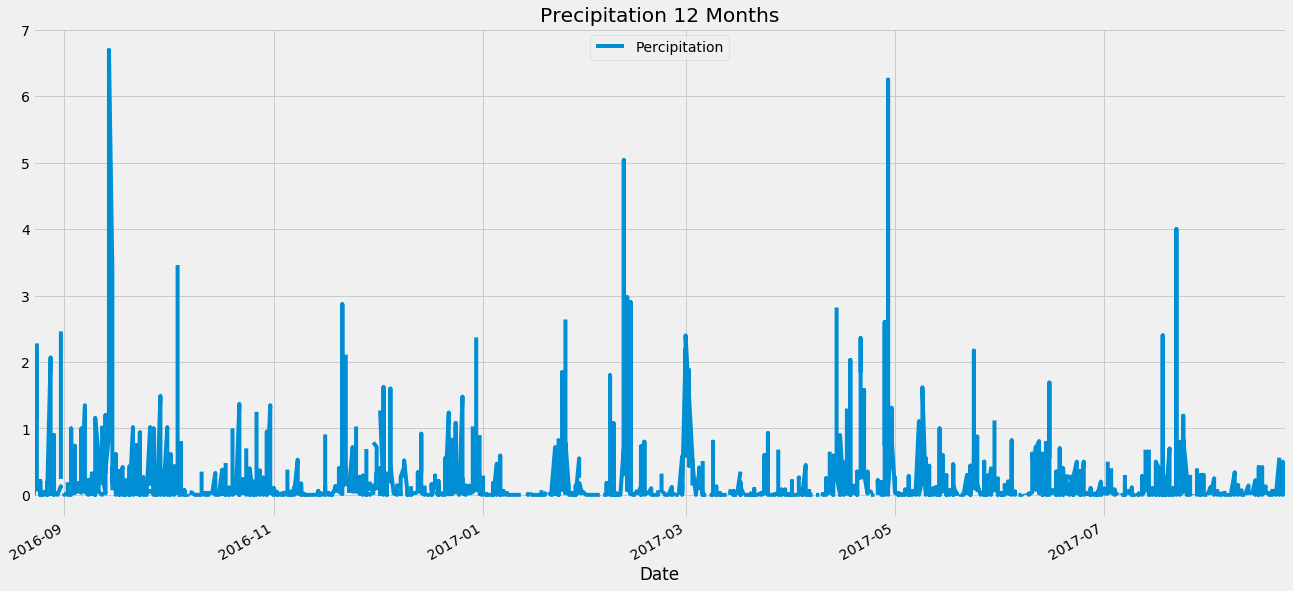

In [54]:
# Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(precipitation_list, columns=['Percipitation', 'Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# Set index to date
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df = df.sort_values(by='Date',ascending=True)


df.plot(title="Precipitation 12 Months")
plt.legend(loc='upper center')
plt.savefig("Precipitation.png")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

![precipitation](Images/precipitation.png)

In [57]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = df.describe()
print(summary)

       Percipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


![describe](Images/describe.png)

In [68]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [63]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).\
group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [64]:
most_active_station=active_stations[0][0]
most_active_station

'USC00519281'

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
.filter(Measurement.station == most_active_station).all()           
print(temp)

[(54.0, 71.66378066378067, 85.0)]


In [66]:
lowesttemp = session.query(func.min(Measurement.tobs))\
.filter(Measurement.station == most_active_station).all()
lowesttemp

[(54.0)]

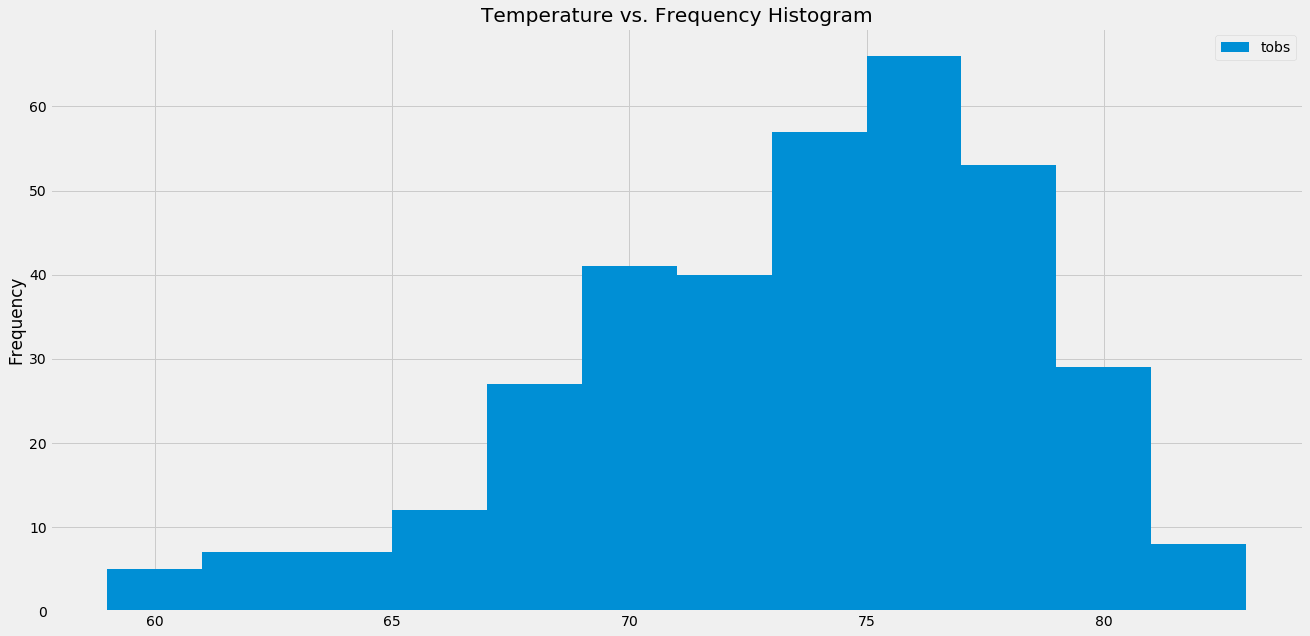

In [67]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_list = []
highest_temp = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= '2016-08-23')
temp_df = pd.DataFrame(highest_temp, columns=['tobs'])
temp_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.savefig("TemperaturevsFrequency.png")



![precipitation](Images/station-histogram.png)

In [69]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [83]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ptrip = calc_temps('2011-02-28', '2011-03-05')
ptrip

[(61.0, 69.75510204081633, 75.0)]

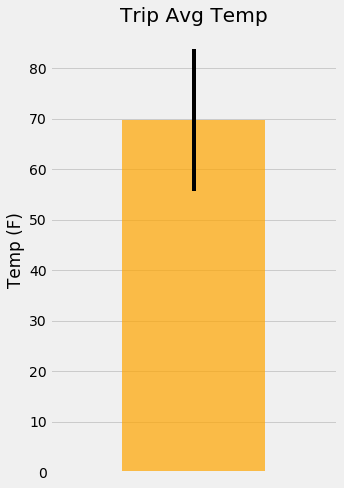

In [106]:
#create dataframe for trip average
trip_avg_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg_df.plot.bar(y='tavg', yerr=(trip_avg_df['tmax'] - trip_avg_df['tmin']), 
title='Trip Avg Temp', color='orange', alpha=0.7, figsize=(5,7))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Trip Average Temp.png")
plt.show()

In [139]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2012-02-28', '2012-03-05'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.05), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


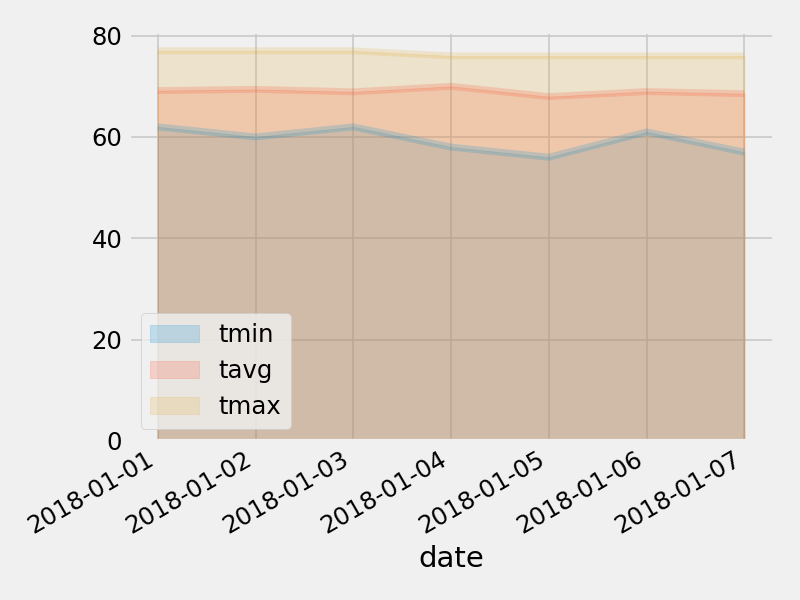

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
